# can we tracec the reason for the deep @ $\phi_\mu\sim0$ ?

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [2]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
8245 selected CC1p events overlay


## divide into 3 dimentions: 
$\vec{p} _{\mu}$
and separately
$\vec{p} _{p}$

In [4]:
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
print 'bins1,bins2,bins3:',bins1,bins2,bins3

bins1,bins2,bins3: [ 0.2    0.441  0.682  0.923  1.164  1.405] [-0.5  -0.21  0.08  0.37  0.66  0.95] [-180. -108.  -36.   36.  108.  180.]


In [33]:
def compute_Xsec_in_3d(beam_on=None,beam_off=None
                       ,generated_CC1p=None,selected_CC1p=None,overlay=None
                       ,NBins=5
                       ,eff_play_option = 'eff=0 at phi ~ 0' # 'eff x 3 at phi ~ 0'
                      ):
    # the return is a dictionary of results    
    for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
    global bins1,bins2,bins3,N1,N2,N3
    bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
    N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
        
    h = dict()
    keys = ['on','off scaled','generated','CC1p','CC1p scaled','B','eff','eff err'
              ,'Xsec','Xsec err','mc-Xsec','mc-Xsec err','generated-Xsec','generated-Xsec err']
    for key in keys: h[key] = np.zeros((N1,N2,N3))
    N = dict()
    for i_P in range(N1):#{
        Pmin,Pmax = bins1[i_P],bins1[i_P+1]
        P_bin_width = Pmax - Pmin
        
        for i_cos_theta in range(N2):#{
            cos_theta_min,cos_theta_max = bins2[i_cos_theta],bins2[i_cos_theta+1]
            cos_theta_bin_width = cos_theta_max - cos_theta_min

            for i_phi in range(N3):#{
                phi_min,phi_max = bins3[i_phi],bins3[i_phi+1]
                phi_bin_width = phi_max - phi_min
                
                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width

                beam_on_in_bin = sam_in_3d_bin(beam_on,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max)
                N['on'] = len(beam_on_in_bin)
                h['on'][i_P][i_cos_theta][i_phi] = N['on']

                Xsec_in_bin , Xsec_err_in_bin = 0 , 0
                mc_Xsec_in_bin , mc_Xsec_err_in_bin = 0 , 0
                gen_Xsec_in_bin , gen_Xsec_err_in_bin = 0 , 0

                N['off'] = len(sam_in_3d_bin(beam_off,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max))
                N['off scaled'] = N['off']*OffBeam_scaling
                h['off scaled'][i_P][i_cos_theta][i_phi] = N['off scaled']


                N['generated'] = len(sam_in_3d_bin(generated_CC1p,
                                               'truth_Pmu',Pmin,Pmax,
                                               'truth_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'truth_Pmu_phi',phi_min,phi_max) )
                N['generated scaled'] = N['generated']*Nevents['f(POT)']
                h['generated'][i_P][i_cos_theta][i_phi] = N['generated']



                N['CC1p'] = len(sam_in_3d_bin(selected_CC1p,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max) )
                h['CC1p'][i_P][i_cos_theta][i_phi] = N['CC1p']

                N['CC1p scaled'] = N['CC1p']*Nevents['f(POT)']
                h['CC1p scaled'][i_P][i_cos_theta][i_phi] = N['CC1p scaled']

                   
                N['ovrelay'] = len(sam_in_3d_bin(overlay,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max) )
                N['ovrelay scaled'] = N['ovrelay']*Nevents['f(POT)']

                    
                B, B_err = N['ovrelay scaled'] - N['CC1p scaled'] , np.sqrt(N['ovrelay scaled'] - N['CC1p scaled'])
                h['B'][i_P][i_cos_theta][i_phi] = B

                eff, eff_err = get_eff(Ngen=N['generated'] , Nsel=N['CC1p'])
                eff_data = eff_mc = eff

                if eff_play_option == 'eff=0 at phi ~ 0':
                    if i_phi==(N3/2):
                        eff, eff_err = 0, 0
                        eff_data = eff_mc = eff
                    
                if eff_play_option == 'eff / 3 at phi ~ 0':
                    if i_phi==(N3/2): 
                        eff_data, eff_err = 0.333333*eff, eff_err
                        eff_mc, eff_err = eff, eff_err



                h['eff'][i_P][i_cos_theta][i_phi] = eff
                h['eff err'][i_P][i_cos_theta][i_phi] = eff_err


                    
                Xsec_in_bin,Xsec_err_in_bin = compute_Xsec(Non=N['on'], Noff=N['off'], B=B, eff=eff_data, 
                                                               bin_width = bin_width,
                                                               Non_err = np.sqrt(N['on']),
                                                               Noff_err= np.sqrt(N['off']),
                                                               B_err   = B_err,eff_err = eff_err)
                    
                mc_Xsec_in_bin,mc_Xsec_err_in_bin = compute_Xsec(Non=N['CC1p scaled'], eff=eff_mc,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['CC1p'])*Nevents['f(POT)'],
                                                                     eff_err = eff_err)
                    
                gen_Xsec_in_bin,gen_Xsec_err_in_bin = compute_Xsec(Non=N['generated scaled'], eff=1,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['generated'])*Nevents['f(POT)'])

                h['Xsec'][i_P][i_cos_theta][i_phi] = Xsec_in_bin
                h['Xsec err'][i_P][i_cos_theta][i_phi] = Xsec_err_in_bin
                h['mc-Xsec'][i_P][i_cos_theta][i_phi] = mc_Xsec_in_bin
                h['mc-Xsec err'][i_P][i_cos_theta][i_phi] = mc_Xsec_err_in_bin
                h['generated-Xsec'][i_P][i_cos_theta][i_phi] = mc_Xsec_in_bin
                h['generated-Xsec err'][i_P][i_cos_theta][i_phi] = mc_Xsec_err_in_bin
                # if N['on']>0:#{#} if N['on'] > 0
            #} i_Pmu_phi
        #} i_Pmu_cos_theta
    #} i_Pmu
    print 'done.'    
    return h

# “killing” the bin at $\phi_\mu \sim 0$ 

In [10]:
h_eff_0_at_phi_0 = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                                      ,NBins=5
                                      ,eff_play_option = 'eff=0 at phi ~ 0' )

done.


In [16]:
h = h_eff_0_at_phi_0

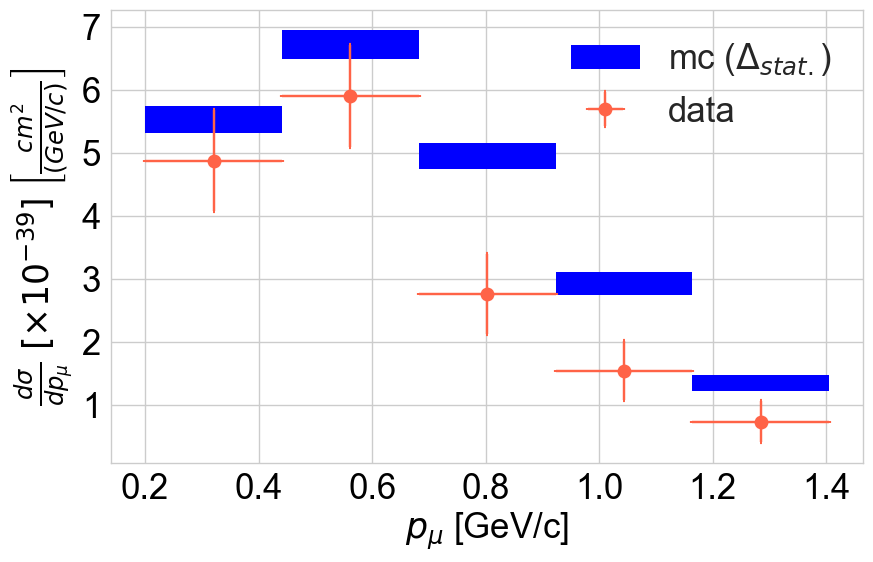

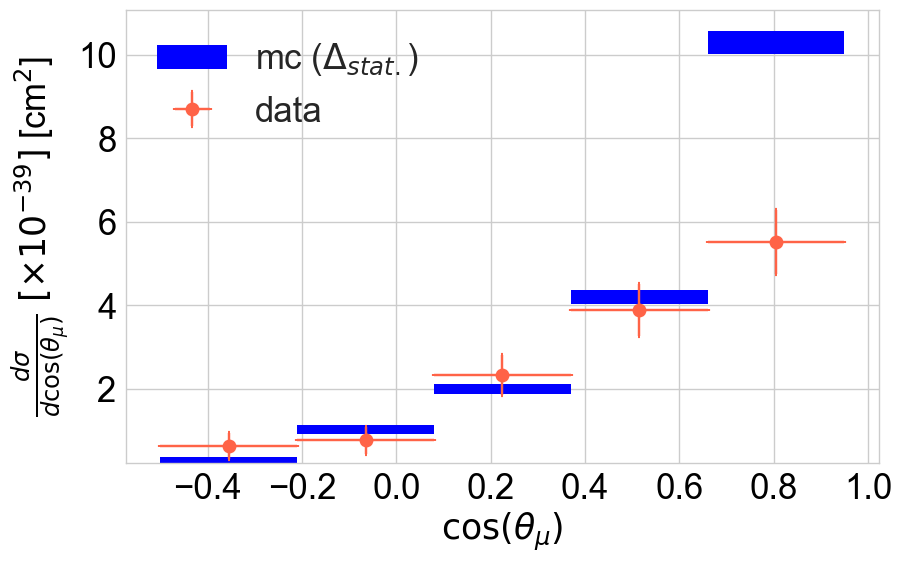

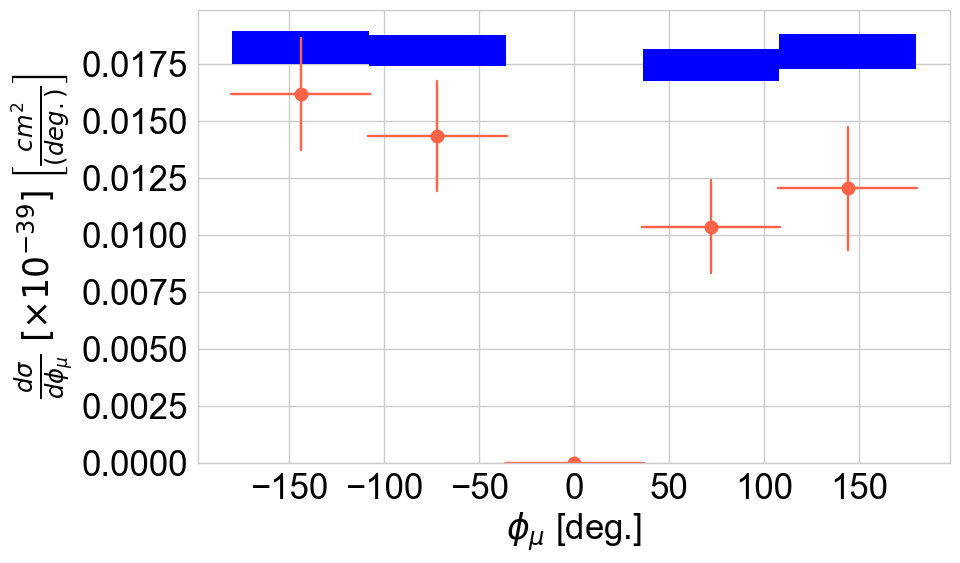

In [18]:
Xsec_1d,Xsec_1d_err = np.zeros(N1),np.zeros(N1)
mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N1),np.zeros(N1)

for i_P in range(N1):#{
    Xsec_1d_err_sq_sum = 0
    mc_Xsec_1d_err_sq_sum = 0

    for i_cos_theta in range(N2):#{
        cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_1d[i_P] += h['Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            mc_Xsec_1d[i_P] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_P] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_P] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d = np.array(Xsec_1d)
Xsec_1d_err = np.array(Xsec_1d_err)
mc_Xsec_1d = np.array(mc_Xsec_1d)
mc_Xsec_1d_err = np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'Pmu'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel+' ['+units+']' if units is not None else Vlabel
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units)
         ,do_add_legend=True)
#-------------------------------
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N2),np.zeros(N2),np.zeros(N2),np.zeros(N2)
for i_cos_theta in range(N2):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_1d[i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
            mc_Xsec_1d[i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_cos_theta] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_cos_theta] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'cos(theta(mu))'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'[cm$^{2}$]')
         ,do_add_legend=True)
#-------------------------------
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N3),np.zeros(N3),np.zeros(N3),np.zeros(N3)
for i_phi in range(N3):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]            
            Xsec_1d[i_phi] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
            mc_Xsec_1d[i_phi] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
        #}
    #}        
    Xsec_1d_err[i_phi] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_phi] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'phi(mu)'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel+' ['+units+']'
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units)
         ,do_add_legend=False)


# “fixing” by a factor of 1/3 to the efficiency at $\phi_\mu \sim 0$ 

In [34]:
h_3eff_at_phi_0 = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                                      ,NBins=5
                                      ,eff_play_option = 'eff / 3 at phi ~ 0')

done.


In [35]:
h = h_3eff_at_phi_0

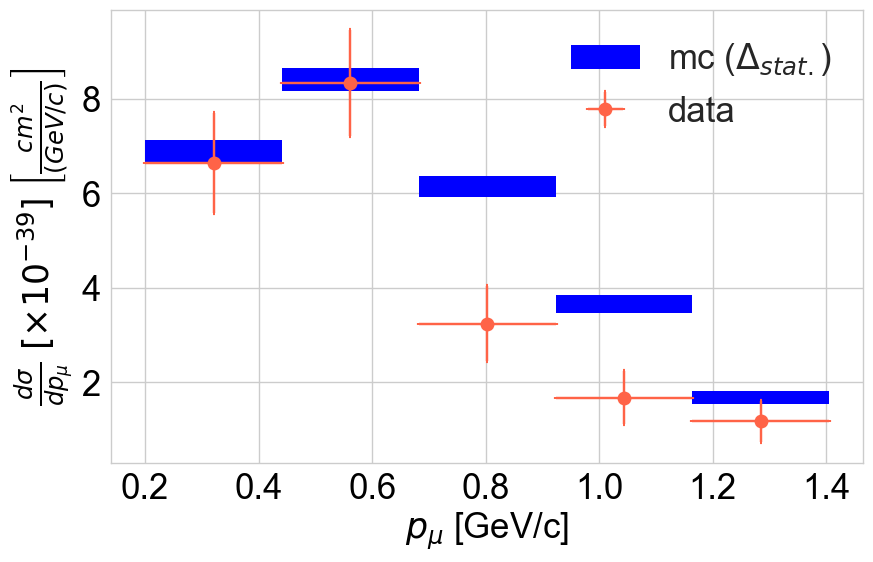

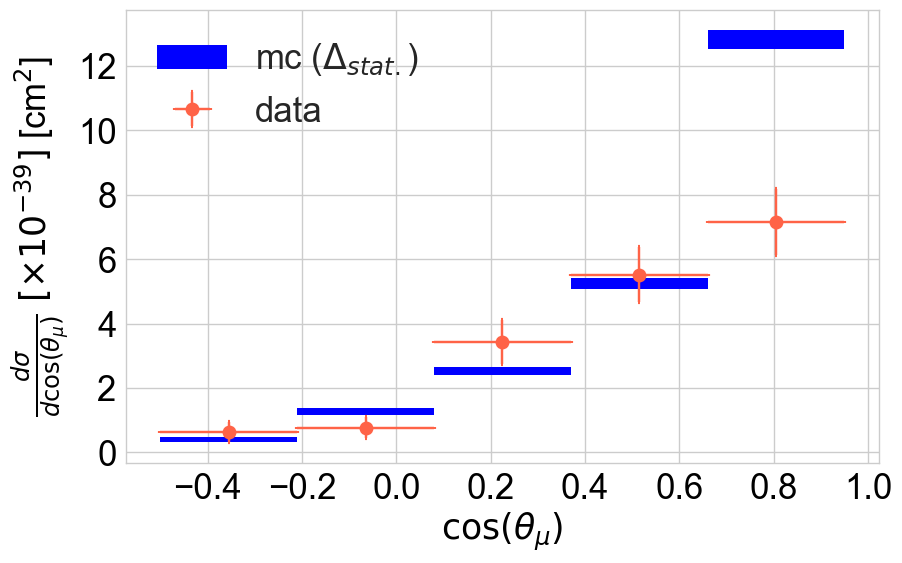

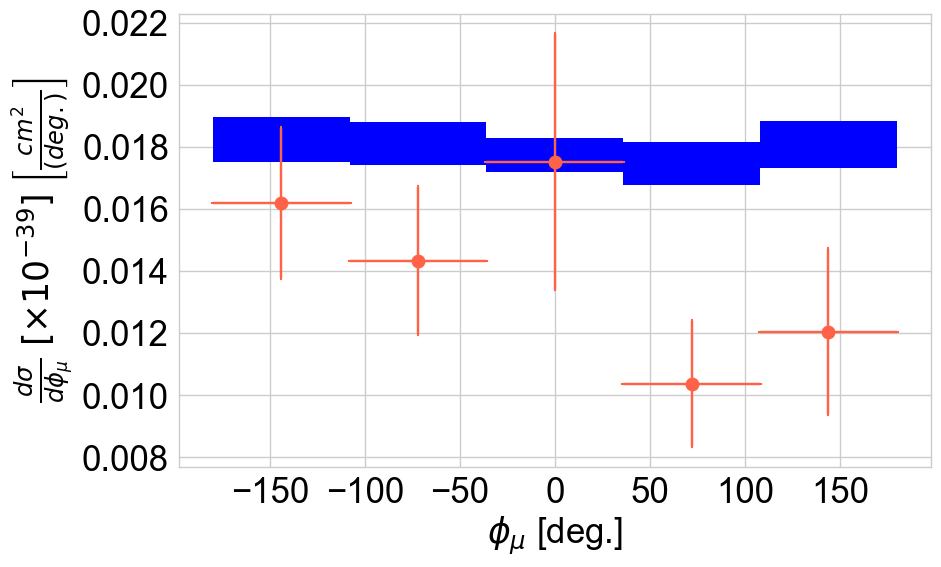

In [36]:
Xsec_1d,Xsec_1d_err = np.zeros(N1),np.zeros(N1)
mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N1),np.zeros(N1)

for i_P in range(N1):#{
    Xsec_1d_err_sq_sum = 0
    mc_Xsec_1d_err_sq_sum = 0

    for i_cos_theta in range(N2):#{
        cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_1d[i_P] += h['Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            mc_Xsec_1d[i_P] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_P] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_P] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d = np.array(Xsec_1d)
Xsec_1d_err = np.array(Xsec_1d_err)
mc_Xsec_1d = np.array(mc_Xsec_1d)
mc_Xsec_1d_err = np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'Pmu'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel+' ['+units+']' if units is not None else Vlabel
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units)
         ,do_add_legend=True)
#-------------------------------
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N2),np.zeros(N2),np.zeros(N2),np.zeros(N2)
for i_cos_theta in range(N2):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_1d[i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
            mc_Xsec_1d[i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_cos_theta] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_cos_theta] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'cos(theta(mu))'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'[cm$^{2}$]')
         ,do_add_legend=True)
#-------------------------------
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N3),np.zeros(N3),np.zeros(N3),np.zeros(N3)
for i_phi in range(N3):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]            
            Xsec_1d[i_phi] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
            mc_Xsec_1d[i_phi] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
        #}
    #}        
    Xsec_1d_err[i_phi] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_phi] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
sns.set_style("whitegrid");
observable = 'phi(mu)'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel+' ['+units+']'
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units)
         ,do_add_legend=False)

